In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from venn import venn
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import qgrid

In [3]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
seed = 42

In [5]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

# compute less correlated proteins

In [13]:
meta = pd.read_csv("../../data/E0022_P06_final_sample_map_no_control.txt", sep='\t')
protein_RUV = pd.read_csv("../../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt", sep='\t')

In [14]:
ccle_protein_common = pd.read_csv("../../data/ccle/protein_matrix_common_ruv.tsv", sep='\t')

In [15]:
rna_raw = pd.read_csv("../../data/rna/rnaseq_voom.csv", index_col=0).T

rna_raw.index.name='SIDM'

rna_raw = rna_raw.reset_index()

In [16]:
rna_sample = pd.merge(rna_raw,
                      meta[['SIDM',
                            'Cell_line']].drop_duplicates()).drop(['SIDM'],
                                                                  axis=1)
# rna_sample = rna_sample.set_index(['Cell_line'])

In [18]:
corr_dict_sanger = {'protein': [], 'corr': []}
gene_not_found = []
protein_not_found = []
for protein in protein_RUV.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(protein_RUV[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict_sanger['protein'].append(protein)
        corr_dict_sanger['corr'].append(pearsonr(data.iloc[:, 1], data.iloc[:, 2])[0])
corr_dict_sanger = pd.DataFrame(corr_dict_sanger)

In [19]:
corr_dict_ccle = {'protein': [], 'corr': []}
gene_not_found = []
protein_not_found = []
for protein in ccle_protein_common.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(ccle_protein_common[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict_ccle['protein'].append(protein)
        corr_dict_ccle['corr'].append(pearsonr(data.iloc[:, 1], data.iloc[:, 2])[0])
corr_dict_ccle = pd.DataFrame(corr_dict_ccle)

In [20]:
corr_dict_merged = pd.merge(corr_dict_sanger, corr_dict_ccle, on=['protein'], suffixes=['_sanger', '_ccle'])

In [21]:
corr_dict_merged.head()

,protein,corr_sanger,corr_ccle
0,1433B_HUMAN,0.215776,0.434546
1,1433E_HUMAN,0.233660,0.472237
2,1433F_HUMAN,0.338888,0.519997
3,1433G_HUMAN,0.457690,0.488445
4,1433S_HUMAN,0.464330,0.772466


In [22]:
corr_dict_merged['corr_avg'] = corr_dict_merged.apply(
    lambda row: np.average([row['corr_sanger'], row['corr_ccle']]), axis=1)
corr_dict_merged['corr_diff'] = corr_dict_merged.apply(
    lambda row: row['corr_sanger'] - row['corr_ccle'], axis=1)

In [23]:
corr_dict_merged = corr_dict_merged[['protein', 'corr_sanger', 'corr_ccle', 'corr_diff', 'corr_avg']]

In [24]:
corr_dict_merged

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
0,1433B_HUMAN,0.215776,0.434546,-0.218770,0.325161
1,1433E_HUMAN,0.233660,0.472237,-0.238577,0.352949
2,1433F_HUMAN,0.338888,0.519997,-0.181109,0.429442
3,1433G_HUMAN,0.457690,0.488445,-0.030755,0.473067
4,1433S_HUMAN,0.464330,0.772466,-0.308137,0.618398
...,...,...,...,...,...
3161,ZO2_HUMAN,0.559510,0.857492,-0.297982,0.708501
3162,ZPR1_HUMAN,0.438462,0.577285,-0.138823,0.507873
3163,ZRAB2_HUMAN,0.389210,0.359832,0.029378,0.374521
3164,ZW10_HUMAN,0.257437,0.329193,-0.071756,0.293315


In [16]:
corr_dict_merged[corr_dict_merged['corr_diff'].abs() < 0.1].sort_values(
    by=['corr_avg']).head(100)

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
1,HBE_HUMAN,-0.163753,-0.071943,-0.091809,-0.117848
4,NDUAD_HUMAN,-0.076566,0.003870,-0.080437,-0.036348
5,FA5_HUMAN,0.006907,-0.078371,0.085279,-0.035732
6,NU205_HUMAN,-0.027487,-0.032571,0.005084,-0.030029
9,GFAP_HUMAN,-0.031614,0.019894,-0.051508,-0.005860
...,...,...,...,...,...
155,TOM22_HUMAN,0.168695,0.085909,0.082787,0.127302
156,UBL5_HUMAN,0.083139,0.171555,-0.088416,0.127347
157,SKIV2_HUMAN,0.114160,0.141088,-0.026928,0.127624
159,TBB4B_HUMAN,0.127417,0.128439,-0.001022,0.127928


In [19]:
corr_dict_merged.sort_values(
    by=['corr_avg']).to_csv("../../data/protein_rna_correlations.csv",
                            index=False)

In [20]:
corr_dict_merged[corr_dict_merged['protein']=='LMNA_HUMAN']

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
1411,LMNA_HUMAN,0.868709,0.67253,0.19618,0.77062


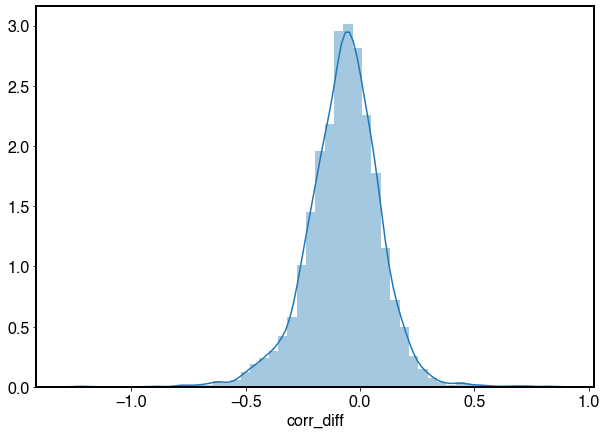

In [21]:
sns.distplot(corr_dict_merged['corr_diff'])

# tissue type features

In [784]:
proteins = np.array([x for x in protein_RUV.columns if '_HUMAN' in x])

In [785]:
lgbm_shap_values = pickle.load(open("../../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "rb"))

topN = 20
shap_tissue_set = []
for tissue_shap in lgbm_shap_values:
    shap_top_proteins = proteins[np.argsort(-np.mean(np.abs(tissue_shap),axis=0))][:topN]
    shap_tissue_set.extend([f"{x}" for x in shap_top_proteins])
shap_tissue_set = set(shap_tissue_set)

# feature importance analysis

In [10]:
corr_dict_merged = pd.read_csv("../../data/protein_rna_correlations.csv")

In [9]:
qgrid.show_grid(corr_dict_merged)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [108]:
target_proteins = corr_dict_merged[corr_dict_merged['corr_diff'].abs(
) < 0.1].sort_values('corr_avg').head(200)['protein']
drug_meta = pd.read_csv("../../data/drug/drug_info.csv")
FDA_approved_id = drug_meta[drug_meta['FDA_Approved']=='Yes']['drug_id'].values

In [109]:
drug_ttest = pd.read_csv("../../data/drug/dl_ttest_df.csv")

In [110]:
drugs_improved = drug_ttest[(drug_ttest['pvalue'] < 0.1) & (
    drug_ttest['protein_predictive_power'] >
    drug_ttest['RNA_predictive_power'])]

In [111]:
drug_score = pd.read_csv("../../data/drug/final_drug_scores_eg_id.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [112]:
drug_list_FDA = [x for x in drug_list if x in FDA_approved_id]

In [113]:
topN = 100

## original

In [429]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006181311_ruv_min_300_eg_id.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006201223_ruv_min_300_eg_id.csv")
df_shap = pd.read_csv("../../result_files/shap/test_63_202006211344_eg_id.csv")

In [430]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-430-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-430-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-430-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [431]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
EXOS2_HUMAN     6
FA5_HUMAN       7
EXOS1_HUMAN     9
VTNC_HUMAN     10
LIN7C_HUMAN    19
dtype: int64

In [432]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
UQCC2_HUMAN    14
SDHF2_HUMAN    16
RABL3_HUMAN    17
FA5_HUMAN      23
VTNC_HUMAN     25
dtype: int64

In [433]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
LAS1L_HUMAN     9
TBB4B_HUMAN    20
RABL3_HUMAN    26
ITIH2_HUMAN    30
VTNC_HUMAN     41
dtype: int64

In [29]:
all_genes = []

In [30]:
for x in res_rf['gene'].unique():
#     print(x)
    all_genes.append(x)

In [31]:
for x in res_en['gene'].unique():
#     print(x)
    all_genes.append(x)

In [32]:
for x in res_shap['gene'].unique():
#     print(x)
    all_genes.append(x)
all_genes = set(all_genes)

In [33]:
for x in all_genes:
    print(x)

CS
PSMA7
NUP155
GTF3C3
MRPL11
PRIM2
MRPL4
NDUFB11
SDHAF2
PUF60
MRPL15
DPF2
RPL13
BMS1
GPKOW
GTF3C5
CHTOP
TP53RK
SUPT4H1
RANGAP1
SLIRP
DPM1
ATP5PD
CA1
NDUFB1
MRPL2
DNTTIP2
SELENOH
UQCC2
TUBB4B
RPS4X
HBE1
RBM8A
NDUFS6
NFYB
F5
PPP2R1B
HYPK
NDUFAF3
DDX41
YBX1
RPL15
PFDN2
PDZD11
BSG
COX7A2L
RPL12
MRPL16
EIF3A
RFC5
RPL36
DDX5
RPL35A
EIF3M
SSR4
RSL1D1
COL6A3
RPA3
UQCRB
MRPL48
RPL27A
EXOSC9
LSM3
EIF3C
CCT2
RPS29
RHOT1
ATP6V1E1
RPL18A
UQCRH
ZNF593
MPHOSPH10
RPL9
DCAF13
NOP14
GNA13
MRPS18B
MRPL18
MRPS36
AP3M1
RPL27
ETF1
EXOSC1
NDUFV1
EXOSC8
VTN
EXOSC7
GPX4
GNL2
RPS19
PSMA5
COPS7A
FAM207A
CPSF1
TRA2A
RPL31
NDUFS1
RPS14
RBMX2
AAAS
COX5A
IMP4
NDUFS5
NOC4L
EMC2
LIN7C
RPL14
RPS21
EXOSC5
PDPR
TSG101
NCBP2
RPS25
EXOSC2
UBL5
POLG
MRPS34
TMCO1
CSTF2T
NGDN
DNAJC11
RPS15
RBM12B
RABL3
NRBP1
HSPA8
GPAA1
LAS1L
SPATA5L1
NCLN
RPL29
INTS3
NDUFS7
RPL23
SKIV2L
EDF1
PSMC2
CBX3
SAMM50
TBL3
FAR1
NDUFS3
WDR36
EHMT2
MRPL22
CDK4
RPL4
UTP15
PSMC5
PCCB
PHF14
ITIH2
NUP107


In [34]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
34,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
194,1007;Docetaxel;GDSC2,RT36_HUMAN,1,MRPS36
92,1386;Doxorubicin;GDSC1,VTNC_HUMAN,1,VTN
100,1495;Olaparib;GDSC1,RT36_HUMAN,1,MRPS36
20,1004;Vinblastine;GDSC1,RL23_HUMAN,1,RPL23
48,1017;Olaparib;GDSC1,EMC2_HUMAN,1,EMC2
13,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN
72,119;Lapatinib;GDSC1,BASI_HUMAN,2,BSG
25,1004;Vinblastine;GDSC1,UQCC2_HUMAN,2,UQCC2
70,1175;Rucaparib;GDSC1,RT36_HUMAN,3,MRPS36


In [35]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
19,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
76,1386;Doxorubicin;GDSC1,VTNC_HUMAN,0,VTN
80,1393;Gemcitabine;GDSC1,VTNC_HUMAN,1,VTN
5,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN
95,37;Crizotinib;GDSC1,AP3M1_HUMAN,1,AP3M1
119,1543;SN-38;GDSC1,VTNC_HUMAN,1,VTN
3,1054;Palbociclib;GDSC1,RM16_HUMAN,2,MRPL16
59,1259;Talazoparib;GDSC1,FA5_HUMAN,2,F5
110,1535;Paclitaxel (0.005);GDSC1,FACR1_HUMAN,2,FAR1
177,1199;Tamoxifen;GDSC2,CAH1_HUMAN,3,CA1


In [36]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
52,274;Belinostat;GDSC1,TBB4B_HUMAN,3,TUBB4B
117,1949;Venetoclax;GDSC2,VTNC_HUMAN,3,VTN
21,1032;Afatinib;GDSC1,BASI_HUMAN,3,BSG
4,238;Idelalisib;GDSC1,TBB4B_HUMAN,3,TUBB4B
55,306;Fedratinib;GDSC1,TBB4B_HUMAN,4,TUBB4B
30,119;Lapatinib;GDSC1,BASI_HUMAN,4,BSG
48,155;Ponatinib;GDSC1,TBB4B_HUMAN,5,TUBB4B
72,1909;Venetoclax;GDSC2,VTNC_HUMAN,5,VTN
51,249;Cabozantinib;GDSC1,TBB4B_HUMAN,6,TUBB4B
60,438;Panobinostat;GDSC1,VTNC_HUMAN,8,VTN


In [37]:
res_en[res_en['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
19,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
76,1386;Doxorubicin;GDSC1,VTNC_HUMAN,0,VTN
5,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN
80,1393;Gemcitabine;GDSC1,VTNC_HUMAN,1,VTN
119,1543;SN-38;GDSC1,VTNC_HUMAN,1,VTN
67,1372;Trametinib;GDSC1,VTNC_HUMAN,4,VTN
123,1544;SN-38;GDSC1,VTNC_HUMAN,4,VTN
61,1259;Talazoparib;GDSC1,VTNC_HUMAN,6,VTN
130,1547;SN-38;GDSC1,VTNC_HUMAN,6,VTN
174,1021;Axitinib;GDSC2,VTNC_HUMAN,8,VTN


In [38]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
117,1949;Venetoclax;GDSC2,VTNC_HUMAN,3,VTN
72,1909;Venetoclax;GDSC2,VTNC_HUMAN,5,VTN
60,438;Panobinostat;GDSC1,VTNC_HUMAN,8,VTN
85,1012;Vorinostat;GDSC2,VTNC_HUMAN,10,VTN
90,1867;Panobinostat;GDSC2,VTNC_HUMAN,11,VTN
119,1989;Imatinib;GDSC2,VTNC_HUMAN,13,VTN
102,1021;Axitinib;GDSC2,VTNC_HUMAN,16,VTN
95,1085;Sorafenib;GDSC2,VTNC_HUMAN,17,VTN
104,1199;Tamoxifen;GDSC2,VTNC_HUMAN,20,VTN
114,1942;Pexidartinib;GDSC2,VTNC_HUMAN,20,VTN


## growth out

In [114]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006182114_ruv_min_300_growth_corrected_eg_id.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006201224_ruv_min_300_growth_corrected_eg_id.csv"
)
df_shap = pd.read_csv(
    "../../result_files/shap/test_25_202006212204_growth_corrected_eg_id.csv")

In [115]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-115-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
QCR1_HUMAN     6
UBL5_HUMAN     6
FA5_HUMAN      7
RFA3_HUMAN     9
VTNC_HUMAN    20
dtype: int64

In [117]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
UBL5_HUMAN     17
SDHF2_HUMAN    20
PDZ11_HUMAN    21
FA5_HUMAN      27
VTNC_HUMAN     45
dtype: int64

In [118]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
SDHF2_HUMAN     4
RABL3_HUMAN    30
FA5_HUMAN      52
VTNC_HUMAN     63
TBB4B_HUMAN    73
dtype: int64

In [119]:
for x in res_rf['gene'].unique():
    print(x) 

HYPK
VTN
PUF60
CCT4
UBL5
EIF3H
EXOSC2
NDUFAF3
NDUFS3
PSMB4
RPS21
SRSF10
MRPL15
MRPL23
MRPS9
MRPS23
SLIRP
CA1
NDUFS5
RPL12
RPL21
RPS14
CCT3
F5
AHCTF1
MRPL18
NDUFS6
EFTUD2
DPM1
EDF1
OGT
MRPL19
MRPL39
SAP30BP
NHP2
PSMC1
RPS29
PIH1D1
RPA3
UTP15
IDH3B
UQCRC1
MRPL13
MRPL50
MRPL14
MRPL16
MPHOSPH10
RPL23A
RPL27
RPL35A
RPS9
ATP6V1E1
COX6C
PDZD11
RPL13A
SAMM50
MRPL58
PCCB
UQCRB
RABL3
SF3B4
NOC4L
RNF20
NUDT21
NDUFA10
NUP107
AP3M1
EXOSC4
EXOSC5
NDUFA4
PSMA2
PSMD11
PSMD8
RBM34
TUBB4B
MATR3
MRPS16
SMU1
YME1L1
PSMC2
PSMC5
PSMB3
PSMC3
RPL18A
RPL30
RNASEH2A
NUP62
MRPL47
EIF2B4
POLR2C
MRPS11
MRPS18B
NDUFA9
LSM3
MRPS26
ATP5ME
PRPF31
RPL7
TBL3


In [120]:
for x in res_en['gene'].unique():
    print(x) 

POMP
VTN
TIMM10
IMP4
MRPL16
UBL5
CA1
PDZD11
GTF3C3
NDUFB11
RABL3
DPM1
F5
ITIH2
MRPL2
SKIV2L
COX7A2L
ATP6V1D
GFAP
DCAF13
NOC4L
TUBB4B
SDHAF2
TOMM22
UTP15
RPA3
AP3M1
ATP6V1E1
HBE1
VPS29
RNASEH2A
NGDN
HYPK
NCBP2
NDUFAF3
GNL3L
NDUFS5
NSA2
NDUFS7


In [121]:
for x in res_shap['gene'].unique():
    print(x) 

F5
TUBB4B
VTN
SDHAF2
RABL3


In [122]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
30,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
191,1008;Methotrexate;GDSC2,RABL3_HUMAN,1,RABL3
13,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN
189,1008;Methotrexate;GDSC2,NDUS6_HUMAN,5,NDUFS6
93,1386;Doxorubicin;GDSC1,VTNC_HUMAN,5,VTN
147,1544;SN-38;GDSC1,PRS8_HUMAN,6,PSMC5
27,1004;Vinblastine;GDSC1,UBL5_HUMAN,6,UBL5
128,37;Crizotinib;GDSC1,TBB4B_HUMAN,6,TUBB4B
8,1054;Palbociclib;GDSC1,NDUF3_HUMAN,6,NDUFAF3
174,1007;Docetaxel;GDSC2,VTNC_HUMAN,7,VTN


In [123]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
117,1511;Epirubicin;GDSC2,PDZ11_HUMAN,0,PDZD11
153,1017;Olaparib;GDSC2,VTNC_HUMAN,0,VTN
147,1851;Ceritinib;GDSC2,FA5_HUMAN,0,F5
165,1021;Axitinib;GDSC2,VTNC_HUMAN,0,VTN
121,1013;Nilotinib;GDSC2,VTNC_HUMAN,0,VTN
12,1004;Vinblastine;GDSC1,UBL5_HUMAN,1,UBL5
15,1006;Cytarabine;GDSC1,VTNC_HUMAN,1,VTN
216,1019;Bosutinib;GDSC2,CAH1_HUMAN,1,CA1
58,1386;Doxorubicin;GDSC1,VTNC_HUMAN,1,VTN
109,1190;Gemcitabine;GDSC2,NDUBB_HUMAN,1,NDUFB11


In [124]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
104,1012;Vorinostat;GDSC2,VTNC_HUMAN,4,VTN
113,1867;Panobinostat;GDSC2,VTNC_HUMAN,5,VTN
69,1909;Venetoclax;GDSC2,VTNC_HUMAN,6,VTN
180,1949;Venetoclax;GDSC2,VTNC_HUMAN,6,VTN
140,1021;Axitinib;GDSC2,VTNC_HUMAN,8,VTN
...,...,...,...,...
25,1021;Axitinib;GDSC1,VTNC_HUMAN,66,VTN
19,1013;Nilotinib;GDSC1,VTNC_HUMAN,78,VTN
52,37;Crizotinib;GDSC1,VTNC_HUMAN,85,VTN
43,249;Cabozantinib;GDSC1,VTNC_HUMAN,87,VTN


In [125]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
44,274;Belinostat;GDSC1,TBB4B_HUMAN,3,TUBB4B
7,238;Idelalisib;GDSC1,TBB4B_HUMAN,3,TUBB4B
104,1012;Vorinostat;GDSC2,VTNC_HUMAN,4,VTN
113,1867;Panobinostat;GDSC2,VTNC_HUMAN,5,VTN
40,179;5-Fluorouracil;GDSC1,TBB4B_HUMAN,5,TUBB4B
69,1909;Venetoclax;GDSC2,VTNC_HUMAN,6,VTN
180,1949;Venetoclax;GDSC2,VTNC_HUMAN,6,VTN
27,11;Paclitaxel;GDSC1,TBB4B_HUMAN,7,TUBB4B
140,1021;Axitinib;GDSC2,VTNC_HUMAN,8,VTN
163,1008;Methotrexate;GDSC2,TBB4B_HUMAN,8,TUBB4B


In [126]:
drug_meta[drug_meta['drug_id'].isin(
    res_shap[res_shap['protein'] == 'VTNC_HUMAN'].sort_values(
        by='rank').head(10)['drug_id'])]

,drug_id,putative_target,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,drug_owner,BROAD_ID,target_pathway,sample_site,growth_properties,webrelease,COSMIC_ID,PUBCHEM,FDA_Approved,sensitive_count
393,1909;Venetoclax;GDSC2,BCL2,HCC1954,NaN,Ductal Breast Carcinoma,Venetoclax,BCL2,Y,Cell Line,"ABT-199, Veneclexta, GDC-0199",CVCL_1259,GDSC2,GDSC,ACH-000859,Apoptosis regulation,Mammary gland/duct,Adherent,Y,749709,49846579,Yes,345
394,1080;Paclitaxel;GDSC2,Microtubule stabiliser,MC-CAR,NaN,Non-Cancerous,Paclitaxel,BCL2;TUBB1,Y,Cell Line,"BMS-181339-01, Taxol, Onxol, Paxene, Praxel, A...",CVCL_1397,GDSC2,GDSC,ACH-002270,Mitosis,Peripheral Blood,Suspension,Y,683665,36314,Yes,586
418,1012;Vorinostat;GDSC2,"HDAC inhibitor Class I, IIa, IIb, IV",HCC1954,NaN,Ductal Breast Carcinoma,Vorinostat,HDAC1;HDAC10;HDAC2;HDAC3;HDAC4;HDAC5;HDAC6;HDA...,Y,Cell Line,"Zolinza, SAHA, suberanilohydroxamic acid, sube...",CVCL_1259,GDSC2,GDSC,ACH-000859,Chromatin histone acetylation,Mammary gland/duct,Adherent,Y,749709,5311,Yes,738
427,1867;Panobinostat;GDSC2,HDAC,ES3,NaN,Ewing's Sarcoma,Panobinostat,HDAC1,Y,Cell Line,"LBH589, Faridak, Farydak, LBH-589, PANOBINOSTA...",CVCL_1199,GDSC2,GDSC,ACH-002104,Chromatin histone acetylation,Unknown,Unknown,N,684055,"6918837, 23725423",Yes,493
434,1851;Ceritinib;GDSC2,ALK,ES3,NaN,Ewing's Sarcoma,Ceritinib,ALK,Y,Cell Line,"LDK378, Zykadia",CVCL_1199,GDSC2,GDSC,ACH-002104,RTK signaling,Unknown,Unknown,N,684055,"57379345, 67973512",Yes,709
444,1089;Oxaliplatin;GDSC2,DNA alkylating agent,MIA-PaCa-2,NaN,Pancreatic Ductal Adenocarcinoma,Oxaliplatin,NaN,Y,Cell Line,Eloxatin,CVCL_0428,GDSC2,GDSC,ACH-000601,DNA replication,Unknown,Semi-Adherent,Y,724870,5310940,Yes,204
456,1021;Axitinib;GDSC2,"PDGFR, KIT, VEGFR",HCC1954,NaN,Ductal Breast Carcinoma,Axitinib,FLT1;KIT;PDGFRA;PDGFRB,Y,Cell Line,"AG-13736, Inlyta",CVCL_1259,GDSC2,GDSC,ACH-000859,RTK signaling,Mammary gland/duct,Adherent,Y,749709,6450551,Yes,328
499,1259;Talazoparib;GDSC2,"PARP1, PARP2",MC-CAR,NaN,Non-Cancerous,Talazoparib,PARP1;PARP2,Y,Cell Line,"BMN-673, BMN 973",CVCL_1397,GDSC2,GDSC,ACH-002270,Genome integrity,Peripheral Blood,Suspension,Y,683665,44819241,Yes,348
536,1949;Venetoclax;GDSC2,BCL2,MC-CAR,NaN,Non-Cancerous,Venetoclax,BCL2,Y,Cell Line,"SN1043963218, ABT-199",CVCL_1397,GDSC2,AZ,ACH-002270,Apoptosis regulation,Peripheral Blood,Suspension,N,683665,NaN,Yes,170
612,2220;Regorafenib;GDSC2,KIT,MC-CAR,NaN,Non-Cancerous,Regorafenib,KIT,Y,Cell Line,SN1054471117,CVCL_1397,GDSC2,AZ,ACH-002270,RTK signaling,Peripheral Blood,Suspension,N,683665,NaN,Yes,99


### combined

In [127]:
df_list = [res_en, res_rf, res_shap]

In [128]:
df_merged = reduce(
    lambda left, right: pd.merge(
        left, right, on=['drug_id', 'protein', 'gene'], how='inner'), df_list)


In [129]:
df_merged['rank_avg'] = np.round(
    df_merged.apply(
        lambda row: np.average([row['rank_x'], row['rank_y'], row['rank']]),
        axis=1)).astype(int) + 1

In [130]:
print(df_merged[['drug_id', 'protein', 'rank_avg']].sort_values(by=['rank_avg']).to_string(index=False))

                drug_id      protein  rank_avg
  1080;Paclitaxel;GDSC2   VTNC_HUMAN         8
   1007;Docetaxel;GDSC2   VTNC_HUMAN         8
    1021;Axitinib;GDSC2   VTNC_HUMAN        10
  1372;Trametinib;GDSC1   VTNC_HUMAN        21
 2220;Regorafenib;GDSC2   VTNC_HUMAN        21
 1004;Vinblastine;GDSC2   VTNC_HUMAN        25
 2048;Vinorelbine;GDSC2   VTNC_HUMAN        27
 2166;Entrectinib;GDSC2   VTNC_HUMAN        29
    281;Alectinib;GDSC1    FA5_HUMAN        33
     51;Dasatinib;GDSC1   VTNC_HUMAN        35
   1005;Cisplatin;GDSC2   VTNC_HUMAN        37
      5;Sunitinib;GDSC1  TBB4B_HUMAN        39
  206;Ruxolitinib;GDSC1   VTNC_HUMAN        44
  2014;Brigatinib;GDSC2   VTNC_HUMAN        50
   428;Pemetrexed;GDSC1   VTNC_HUMAN        55


In [376]:
df_merged[df_merged['drug_id'].isin(drugs_improved['drug_id'])].sort_values(by=['rank_avg'])

,drug_id,protein,rank_x,gene,rank_y,rank,rank_avg
9,1021;Axitinib;GDSC2,VTNC_HUMAN,0,VTN,19,8,10.0
11,1004;Vinblastine;GDSC2,VTNC_HUMAN,5,VTN,47,19,25.0


### union

In [131]:
df_union = pd.concat([res_en, res_rf, res_shap]).sort_values(by='rank')
df_union_growth = df_union.drop_duplicates(['drug_id','protein'])

## PC1

In [66]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006182115_ruv_min_300_pc1_corrected_eg_id.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006201224_ruv_min_300_pc1_corrected_eg_id.csv"
)
df_shap = pd.read_csv(
    "../../result_files/shap/test_25_202006212205_pc1_corrected_eg_id.csv")

In [67]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-67-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
EXOS1_HUMAN    14
SPT4H_HUMAN    14
EXOS2_HUMAN    19
FA5_HUMAN      20
VTNC_HUMAN     35
dtype: int64

In [69]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
CAH1_HUMAN     12
ITIH2_HUMAN    13
SDHF2_HUMAN    19
VTNC_HUMAN     29
FA5_HUMAN      30
dtype: int64

In [70]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
RABL3_HUMAN    11
FA5_HUMAN      12
UBL5_HUMAN     36
VTNC_HUMAN     50
TBB4B_HUMAN    54
dtype: int64

In [71]:
for x in res_rf['gene'].unique():
    print(x) 

ATP5PD
CA1
HYPK
NFYB
NUP107
RPL3
MRPS23
NUDT21
DHX9
ITIH2
NDUFB4
NDUFS3
PAF1
PRPF8
RPL13A
RPL15
RPS13
TOMM22
CNOT1
DCAF13
EIF3H
EXOSC2
EXOSC4
F5
NDUFAF3
NGDN
MRPL16
MRPL47
MRPL53
MRPS15
SUPT4H1
VTN
NDUFS8
MRPL4
WDR18
LIN7C
PTCD3
RPL35A
RPLP0
MRPL18
RPS11
TRMT112
ATP6V1D
RPL27
RPL7A
RPS18
SMU1
UQCC2
EXOSC1
NUP133
RPL34
TOX4
AAAS
ILF2
LSM3
RPL35
MRPL19
MRPL23
PDZD11
MRPL13
MRPL14
MRPL50
DAP3
MRPS34
SNRNP200
PSMB1
UBL5
UFD1
ATP5PB
PSMD1
RPS27A
PSMA2
PSMA4
RPL10
RPL30
RPS29
TPRKB
GFAP
IDH3B
NUP54
PLRG1
RABL3
POLR2B
RPS24
SNX4
VPS25
EXOSC5
UTP15
ATP5MG
UQCRC1
MRPL15
PCCB
MRPL22
MRPL44
RPL18A
RPS9
MPHOSPH10
PMPCB
MRPL2
SDHAF2
PSMD11
PSMD7
SAMM50
TBL3
PSMD3
UQCRH
MRPL39
MRPL43
SNRNP70
CWC15
ATP5PF
NOC4L
POLR2C
MRPS11
SKIV2L
NDUFS5
RNF20
RPL32
NDUFB1
PSMB6
SNRPD1
PSMC1
PSMA6
RPS21
ATP5PO
NSA2
BCAS2
RPL22
AP3M1
PSMA7
PSMB7
PSMD8
TUBB4B
NDUFV2
RPL27A
RPS23
RPS3
NDUFV1
ELOC
RPS16
PSMC5
MRPL48
SNRPB2
RPL21
PSMB3
RPL17
CSNK2B
COX7A2
NDUFA2
RNF40
NDUFS7
SNRPF
SNRPC
DRAP1
NDUFA9
RPL37A
LAS1L
RPL8
EIF

In [72]:
for x in res_en['gene'].unique():
    print(x) 

POMP
PDZD11
CTSG
IMP4
NDUFAF3
SMPD4
MRPL16
TPRKB
UBL5
VTN
CA1
PHF14
SNX4
GTF3C3
F5
COX7A2L
AP3M1
ITIH2
MRPL2
MRPL48
NFYB
POLR2F
SKIV2L
ATP6V1D
GFAP
DCAF13
MPHOSPH10
NGDN
NOC4L
UTP15
DRAP1
NDUFS7
SDHAF2
UQCC2
DES
EIF3C
TOMM22
RABL3
LAS1L
TUBB4B
NDUFS5
RPA3
NDUFB11
AAAS
POLR2L
AATF
MRPL22
VPS25
PSMB6
PSMB7
UQCRH
HYPK
NCBP2
NSA2
MRPL14
MRPS15
MRPL47


In [73]:
for x in res_shap['gene'].unique():
    print(x) 

RABL3
TUBB4B
UBL5
F5
ITIH2
VTN
PFDN4
RPL21
CTSG
UQCRH
SDHAF2
TOX4
PFDN5
ATP5PF
NDUFA9
EXOSC1
RPL35A
IDH3B
SMPD4
PSMB4
RPS24
TOMM22
MRPS34
CNOT1
PSMA7
RPS29
COX7A2
RPL34
LAS1L
COPS3
TBL3


In [155]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
104,1386;Doxorubicin;GDSC1,VTNC_HUMAN,0,VTN
29,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
278,1199;Tamoxifen;GDSC2,NDUS5_HUMAN,0,NDUFS5
157,37;Crizotinib;GDSC1,TBB4B_HUMAN,1,TUBB4B
109,1393;Gemcitabine;GDSC1,VTNC_HUMAN,1,VTN
15,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN
81,1259;Talazoparib;GDSC1,FA5_HUMAN,1,F5
307,1008;Methotrexate;GDSC2,RABL3_HUMAN,1,RABL3
378,1911;Dactinomycin;GDSC2,RT11_HUMAN,2,MRPS11
178,1543;SN-38;GDSC1,FA5_HUMAN,2,F5


In [156]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
103,1543;SN-38;GDSC1,VTNC_HUMAN,0,VTN
146,1199;Tamoxifen;GDSC2,CAH1_HUMAN,0,CA1
71,1393;Gemcitabine;GDSC1,VTNC_HUMAN,0,VTN
66,1386;Doxorubicin;GDSC1,VTNC_HUMAN,0,VTN
106,1544;SN-38;GDSC1,VTNC_HUMAN,0,VTN
112,1547;SN-38;GDSC1,VTNC_HUMAN,0,VTN
110,1546;SN-38;GDSC1,VTNC_HUMAN,0,VTN
15,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN
40,1259;Talazoparib;GDSC1,FA5_HUMAN,0,F5
101,1543;SN-38;GDSC1,FA5_HUMAN,1,F5


In [157]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
7,1006;Cytarabine;GDSC1,VTNC_HUMAN,7,VTN
25,1386;Doxorubicin;GDSC1,VTNC_HUMAN,10,VTN
3,1054;Palbociclib;GDSC1,VTNC_HUMAN,12,VTN
26,1393;Gemcitabine;GDSC1,VTNC_HUMAN,12,VTN
47,1543;SN-38;GDSC1,VTNC_HUMAN,18,VTN
55,1511;Epirubicin;GDSC2,VTNC_HUMAN,18,VTN
68,1867;Panobinostat;GDSC2,VTNC_HUMAN,20,VTN
22,1372;Trametinib;GDSC1,VTNC_HUMAN,20,VTN
24,1373;Dabrafenib;GDSC1,VTNC_HUMAN,21,VTN
81,1021;Axitinib;GDSC2,VTNC_HUMAN,22,VTN


In [158]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
84,2048;Vinorelbine;GDSC2,TBB4B_HUMAN,3,TUBB4B
61,1088;Irinotecan;GDSC2,UBL5_HUMAN,5,UBL5
62,1005;Cisplatin;GDSC2,UBL5_HUMAN,7,UBL5
7,1006;Cytarabine;GDSC1,VTNC_HUMAN,7,VTN
74,1089;Oxaliplatin;GDSC2,TBB4B_HUMAN,9,TUBB4B
25,1386;Doxorubicin;GDSC1,VTNC_HUMAN,10,VTN
4,238;Idelalisib;GDSC1,TBB4B_HUMAN,10,TUBB4B
37,281;Alectinib;GDSC1,TBB4B_HUMAN,10,TUBB4B
39,306;Fedratinib;GDSC1,TBB4B_HUMAN,10,TUBB4B
26,1393;Gemcitabine;GDSC1,VTNC_HUMAN,12,VTN


### combined

In [345]:
df_list = [res_en, res_rf, res_shap]

In [346]:
df_merged = reduce(
    lambda left, right: pd.merge(
        left, right, on=['drug_id', 'protein', 'gene'], how='inner'), df_list)


In [348]:
df_merged['rank_avg'] = df_merged.apply(lambda row:np.average([row['rank_x'], row['rank_y'], row['rank']]), axis=1)

In [349]:
df_merged.sort_values(by=['rank_avg'])

,drug_id,protein,rank_x,gene,rank_y,rank,rank_avg
1,1006;Cytarabine;GDSC1,VTNC_HUMAN,0,VTN,0,7,2.333333
4,1386;Doxorubicin;GDSC1,VTNC_HUMAN,0,VTN,0,10,3.333333
5,1393;Gemcitabine;GDSC1,VTNC_HUMAN,0,VTN,1,12,4.333333
0,1054;Palbociclib;GDSC1,VTNC_HUMAN,1,VTN,1,12,4.666667
7,1543;SN-38;GDSC1,VTNC_HUMAN,0,VTN,3,18,7.000000
2,1259;Talazoparib;GDSC1,VTNC_HUMAN,2,VTN,5,25,10.666667
3,1372;Trametinib;GDSC1,VTNC_HUMAN,5,VTN,12,20,12.333333
6,1498;Selumetinib;GDSC1,VTNC_HUMAN,24,VTN,6,25,18.333333


In [55]:
df_merged[df_merged['drug_id'].isin(drugs_improved['drug_id'])].sort_values(by=['rank_avg'])

,drug_id,protein,rank_x,gene,rank_y,rank,rank_avg
21,1021;Axitinib;GDSC2,VTNC_HUMAN,34,VTN,34,22,30.000000
19,1511;Epirubicin;GDSC2,VTNC_HUMAN,42,VTN,76,18,45.333333


### union

In [74]:
df_union = pd.concat([res_en, res_rf, res_shap]).sort_values(by='rank')
df_union_pc1 = df_union.drop_duplicates(['drug_id','protein'])

## linear models

In [132]:
# df_union = pd.concat([df_union_pc1,
#                       df_union_growth]).sort_values(by='rank').drop_duplicates(
#                           ['drug_id', 'protein'])
# df_union = pd.concat([res_en, res_rf, res_shap]).sort_values(by='rank')
df_union = df_union_growth
df_union = df_union.drop_duplicates(['drug_id','protein'])
df_union = df_union.sort_values(by='rank').drop_duplicates(
                          ['drug_id', 'protein'])

In [133]:
AIP = [name_map_dict[x] for x in target_proteins]

In [134]:
lm_res = pd.read_csv("../../result_files/lm/lm_sklearn_degr_drug_annotated.csv.gz")
lm_res = lm_res[lm_res['fdr']< 0.1]

lm_res_AIP = lm_res[lm_res['x_id'].isin(AIP)]

In [135]:
lm_res_AIP.groupby('x_id').size().sort_values(ascending=False).head(15)

x_id
PSMD11       87
MATR3        85
PRPF31       75
SAMM50       72
YME1L1       70
UBL5         69
NDUFS8       66
HNRNPA2B1    65
PSMA2        62
POLR2C       61
MRPS15       61
DDB1         61
VTN          60
AP3M1        59
GPS1         58
dtype: int64

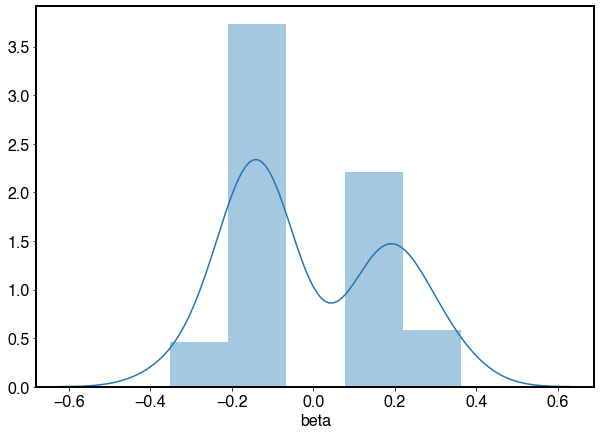

In [136]:
sns.distplot(lm_res_AIP[lm_res_AIP['x_id']=='VTN']['beta'])

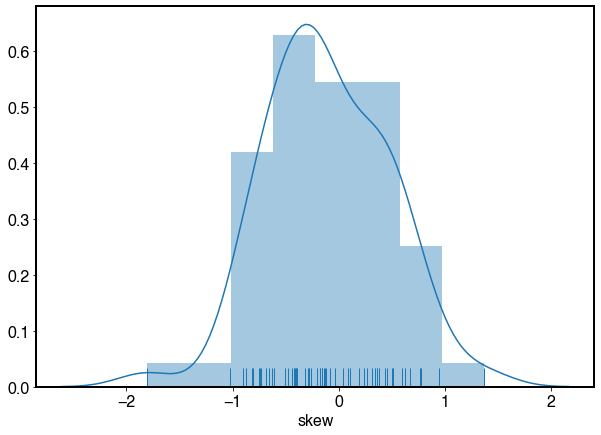

In [137]:
sns.distplot(lm_res_AIP[lm_res_AIP['x_id']=='VTN']['skew'], rug=True)

In [138]:
lm_res_AIP[(lm_res_AIP['x_id']=='VTN')&(lm_res_AIP['skew'] < -1.5)]

,y_id,x_id,n,beta,lr,covs,pval,fdr,target,ppi,chr,chr_pos,attenuated,skew,r2
33212,1373;Dabrafenib;GDSC1,VTN,844,0.212806,13.42701,20,0.000248,0.039097,BRAF,2,17,28370187.5,0,-1.809261,0.430525


In [139]:
df_lm_ml = pd.merge(lm_res_AIP, df_union, left_on=['y_id', 'x_id'], right_on=['drug_id', 'gene'])
df_lm_ml[df_lm_ml['skew']<0][['y_id', 'beta','x_id', 'fdr', 'r2']]

,y_id,beta,x_id,fdr,r2
0,1008;Methotrexate;GDSC2,0.288366,RABL3,0.000007,0.632947
2,1008;Methotrexate;GDSC2,-0.773153,YME1L1,0.000057,0.632947
3,1008;Methotrexate;GDSC2,-0.346492,UBL5,0.000263,0.632947
4,1032;Afatinib;GDSC2,-0.273690,RNASEH2A,0.000424,0.455719
5,1008;Methotrexate;GDSC2,0.738418,NDUFS5,0.000716,0.632947
6,1016;Temsirolimus;GDSC1,0.664561,NHP2,0.004428,0.416907
8,1008;Methotrexate;GDSC2,-0.621676,PUF60,0.005860,0.632947
10,1535;Paclitaxel (0.005);GDSC1,-0.372258,MATR3,0.009027,0.562697
13,1372;Trametinib;GDSC1,0.315597,VTN,0.010062,0.641991
15,1008;Methotrexate;GDSC2,0.440555,NDUFS6,0.018568,0.632947


In [100]:
df_lm_ml = pd.merge(lm_res_AIP, df_union, left_on=['y_id', 'x_id'], right_on=['drug_id', 'gene'])
df_lm_ml[df_lm_ml['skew']<0]

,y_id,x_id,n,beta,lr,covs,pval,fdr,target,ppi,chr,chr_pos,attenuated,skew,r2,drug_id,protein,rank,gene
0,1008;Methotrexate;GDSC2,RABL3,952,0.288366,30.846546,20,2.792587e-08,0.000007,DHFR,-,3,1.207140e+08,0,-0.252054,0.632947,1008;Methotrexate;GDSC2,RABL3_HUMAN,1,RABL3
2,1008;Methotrexate;GDSC2,YME1L1,952,-0.773153,25.267092,20,4.991526e-07,0.000057,DHFR,5+,10,2.713269e+07,1,-0.252054,0.632947,1008;Methotrexate;GDSC2,YMEL1_HUMAN,39,YME1L1
3,1008;Methotrexate;GDSC2,UBL5,868,-0.346492,21.629340,20,3.307535e-06,0.000263,DHFR,4,19,9.829004e+06,1,-0.252054,0.632947,1008;Methotrexate;GDSC2,UBL5_HUMAN,18,UBL5
4,1032;Afatinib;GDSC2,RNASEH2A,726,-0.273690,25.579323,20,4.245647e-07,0.000424,EGFR;ERBB2,-,19,1.281011e+07,1,-0.427342,0.455719,1032;Afatinib;GDSC2,RNH2A_HUMAN,67,RNASEH2A
5,1008;Methotrexate;GDSC2,NDUFS5,806,0.738418,18.700940,20,1.529071e-05,0.000716,DHFR,4,1,3.903048e+07,1,-0.252054,0.632947,1008;Methotrexate;GDSC2,NDUS5_HUMAN,31,NDUFS5
6,1016;Temsirolimus;GDSC1,NHP2,952,0.664561,23.175668,20,1.478564e-06,0.004428,MTOR,2,5,1.781517e+08,1,-0.281819,0.416907,1016;Temsirolimus;GDSC1,NHP2_HUMAN,98,NHP2
8,1008;Methotrexate;GDSC2,PUF60,953,-0.621676,13.002517,20,3.110725e-04,0.005860,DHFR,3,8,1.438228e+08,1,-0.252054,0.632947,1008;Methotrexate;GDSC2,PUF60_HUMAN,17,PUF60
10,1535;Paclitaxel (0.005);GDSC1,MATR3,953,-0.372258,20.421249,20,6.213604e-06,0.009027,NaN,NaN,5,1.393094e+08,0,-0.410140,0.562697,1535;Paclitaxel (0.005);GDSC1,MATR3_HUMAN,32,MATR3
13,1372;Trametinib;GDSC1,VTN,844,0.315597,18.521649,20,1.679854e-05,0.010062,MAP2K1;MAP2K2,-,17,2.837019e+07,0,-0.412926,0.641991,1372;Trametinib;GDSC1,VTNC_HUMAN,9,VTN
15,1008;Methotrexate;GDSC2,NDUFS6,941,0.440555,9.653631,20,1.889777e-03,0.018568,DHFR,4,5,1.808728e+06,1,-0.252054,0.632947,1008;Methotrexate;GDSC2,NDUS6_HUMAN,5,NDUFS6


In [102]:
df_lm_ml[df_lm_ml['skew'] < 0].sort_values(by='skew').to_excel(
    "../../result_files/lm_AIP_ml_growth.xlsx", index=False)

In [193]:
for x in df_lm_ml['x_id'].unique():
    print(x)

RABL3
MATR3
VTN
YME1L1
UBL5
RNASEH2A
NDUFS5
NUP62
MRPL13
NDUFS8
NHP2
TPR
UQCRB
PUF60


# specific proteins

In [19]:
proteins = ['TBB4B_HUMAN', 'VTNC_HUMAN']

In [20]:
corr_dict_merged[corr_dict_merged['protein'].isin(proteins)]

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
72,VTNC_HUMAN,0.028767,0.120954,-0.092187,0.074861
159,TBB4B_HUMAN,0.127417,0.128439,-0.001022,0.127928


# pathway

## AIP from ML

In [92]:
pathway_df = pd.read_csv(
    "../../result_files/toppgene/protein_specific_top_feature_pathways/combined_top100_features_200proteins.txt",
    sep='\t')

In [93]:
pathway_df = pathway_df[(pathway_df['Source'].str.contains('REACTOME')) |
                        (pathway_df['Source'].str.contains('MSig'))]

In [94]:
pathway_df['-log(FDR)'] = -np.log10(pathway_df['q-value FDR B&H'].values)
pathway_df = pathway_df[['Name', '-log(FDR)']]
pathway_df = pathway_df.sort_values(by=['-log(FDR)'], ascending=False)

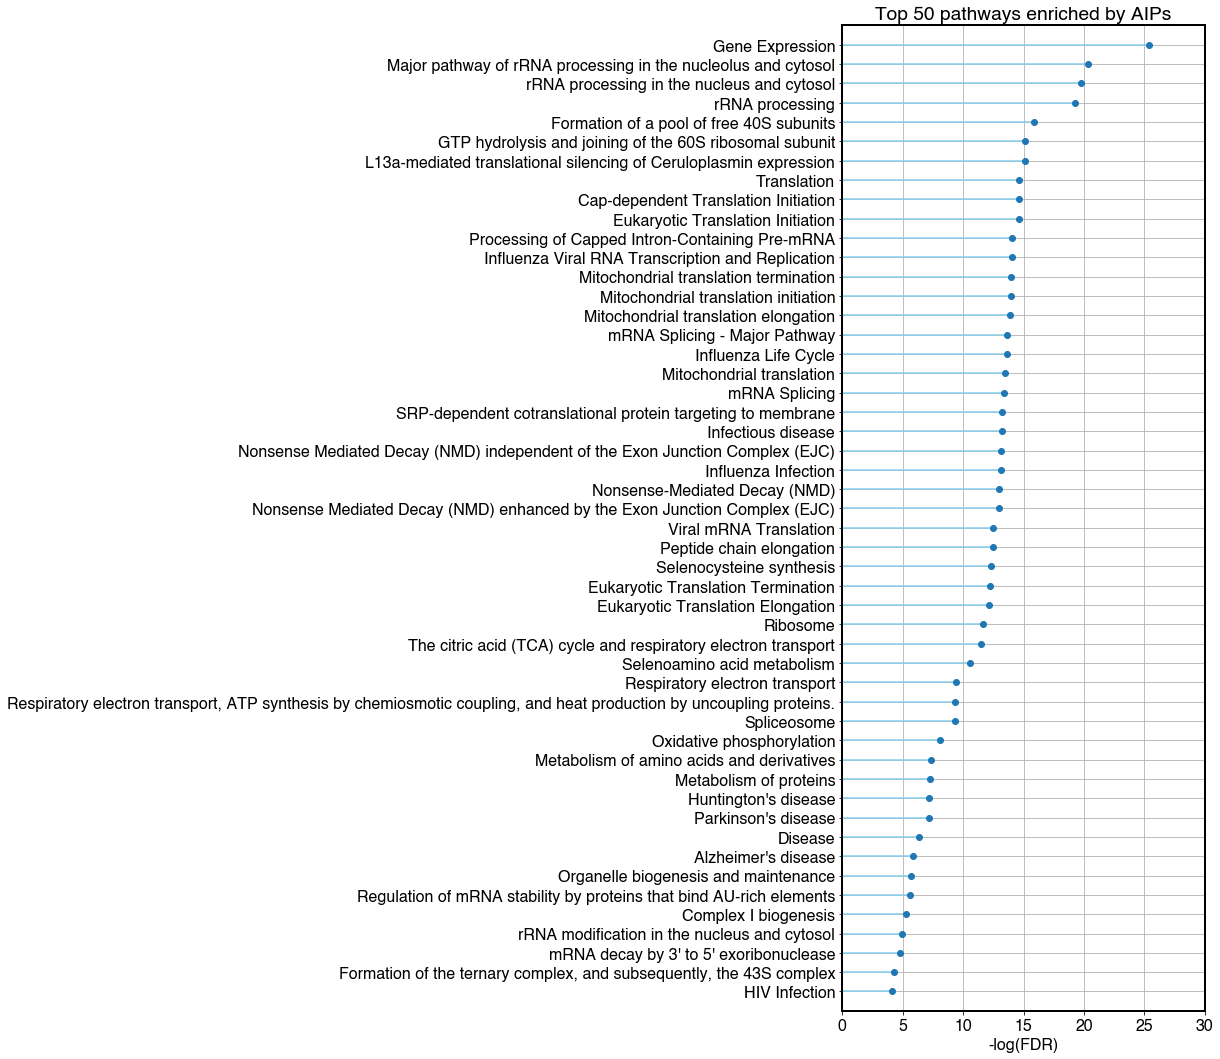

In [96]:
fig = plt.figure(figsize=(18,15))
topN = 50
plt.grid()
plt.hlines(y=range(topN),
           xmin=0,
           xmax=pathway_df['-log(FDR)'][:topN],
           color='skyblue')
plt.plot(pathway_df['-log(FDR)'][:topN], range(topN), "o")
plt.yticks(range(topN), pathway_df['Name'])
plt.xlabel("-log(FDR)")
plt.ylim(-1, topN)
plt.xlim(0, 30)
plt.gca().invert_yaxis()
plt.title("Top 50 pathways enriched by AIPs")

plt.tight_layout()
plt.gcf().subplots_adjust(left=0.7)
plt.savefig("../../plots/drug/Fig4F.pdf", dpi=500)


## AIP from lm

In [224]:
pathway_df = pd.read_csv(
    "../../result_files/toppgene/lm_AIP_top100.txt",
    sep='\t')

In [225]:
pathway_df = pathway_df[(pathway_df['Source'].str.contains('REACTOME')) |
                        (pathway_df['Source'].str.contains('MSig'))]

In [226]:
pathway_df['-log(FDR)'] = -np.log10(pathway_df['q-value FDR B&H'].values)
pathway_df = pathway_df[['Name', '-log(FDR)']]
pathway_df = pathway_df.sort_values(by=['-log(FDR)'], ascending=False)

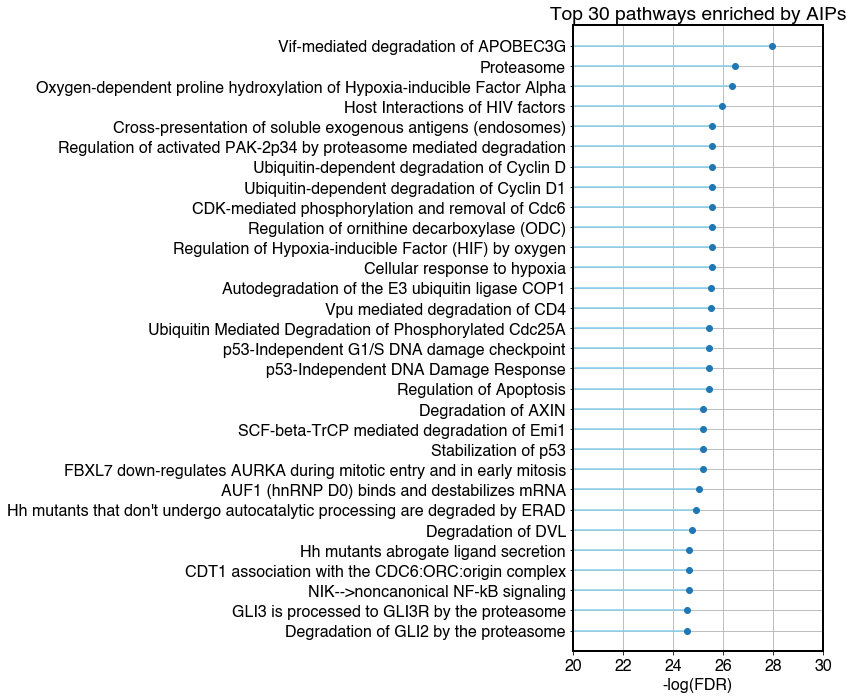

In [274]:
fig = plt.figure(figsize=(12,10))
topN = 30
plt.grid()
plt.hlines(y=range(topN),
           xmin=0,
           xmax=pathway_df['-log(FDR)'][:topN],
           color='skyblue')
plt.plot(pathway_df['-log(FDR)'][:topN], range(topN), "o")
plt.yticks(range(topN), pathway_df['Name'])
plt.xlabel("-log(FDR)")
plt.ylim(-1, topN)
plt.xlim(20, 30)
plt.gca().invert_yaxis()
plt.title("Top 30 pathways enriched by AIPs")

plt.tight_layout()
plt.gcf().subplots_adjust(left=0.68)
plt.savefig("../../plots/drug/lm_AIP_30.pdf", dpi=500)


# single check

In [259]:
corr_dict_merged[corr_dict_merged['protein']=='UBL5_HUMAN']

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
156,UBL5_HUMAN,0.083139,0.171555,-0.088416,0.127347


In [262]:
corr_dict_merged[corr_dict_merged['protein']=='SSRA_HUMAN']

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
2179,SSRA_HUMAN,0.543643,0.581801,-0.038158,0.562722
